Data Exploration

shape: (1296675, 24)

columns:
 ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long', 'is_fraud', 'merch_zipcode']

datatypes:
 Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float

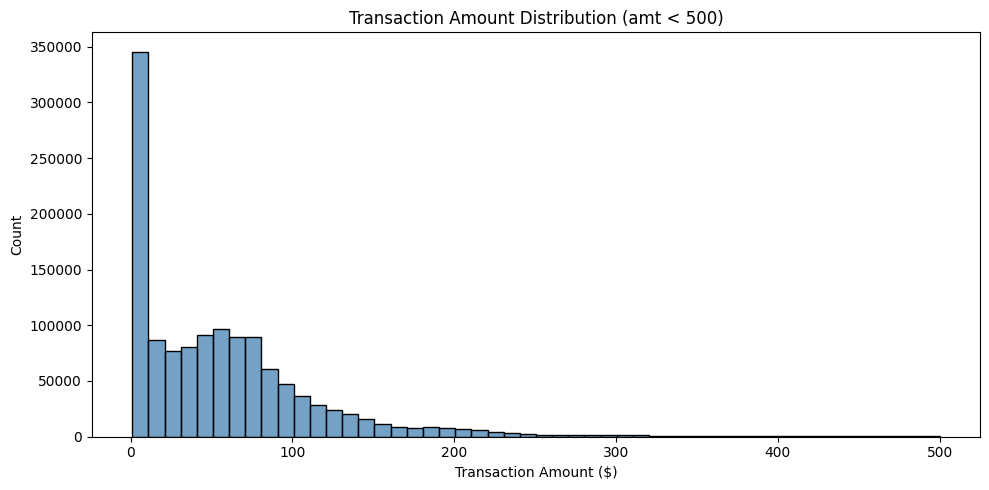


Fraud Distribution:
 is_fraud
0    1289169
1       7506
Name: count, dtype: int64
Fraud %: 0.58 %


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# --- Load Dataset ---
df = pd.read_csv("credit_card_transactions.csv")

# --- Basic Overview ---
print("shape:", df.shape)
print("\ncolumns:\n", df.columns.tolist())
print("\ndatatypes:\n", df.dtypes)
print("\nfirst 5 rows:\n", df.head())

# --- missing values ---
print("\nmissing values:\n", df.isnull().sum())

# --- duplicates ---
print("\nduplicates:\n", df.duplicated().sum())

# --- summary statistics ---
print("\nNumerical summary:\n", df.describe())

# --- Unique counts ---
print("\nUnique Customers:", df['cc_num'].nunique())
print("Unique Merchants:", df['merchant'].nunique())
print("Unique Categories:", df['category'].nunique())
print("Categories:", df['category'].unique())
print("Unique States:", df['state'].nunique())

# -- Transaction Amount Distribution --
plt.figure(figsize=(10,5))
sns.histplot(df[df['amt'] < 500]['amt'], bins=50, color='steelblue')
plt.title('Transaction Amount Distribution (amt < 500)')
plt.xlabel('Transaction Amount ($)')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('amt_distribution.png', dpi=150)
plt.show()

# --- Fraud vs Legitimate Split ---
print("\nFraud Distribution:\n", df['is_fraud'].value_counts())
print("Fraud %:", round(df['is_fraud'].mean() * 100, 2), "%")

In [8]:
# ============================================================
# STEP 2: DATA CLEANING
# ============================================================

# --- Filter out fraud transactions (like a real bank analyst would) ---
df = df[df['is_fraud'] == 0].copy()
print("Rows after removing fraud:", df.shape[0])

# --- Convert transaction datetime ---
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])

# --- Extract time-based features ---
df['trans_year']     = df['trans_date_trans_time'].dt.year
df['trans_month']    = df['trans_date_trans_time'].dt.month
df['trans_day']      = df['trans_date_trans_time'].dt.day
df['trans_hour']     = df['trans_date_trans_time'].dt.hour
df['day_of_week']    = df['trans_date_trans_time'].dt.day_name()
df['month_name']     = df['trans_date_trans_time'].dt.strftime('%b')

# --- Calculate customer age from dob ---
df['dob'] = pd.to_datetime(df['dob'])
df['age'] = (df['trans_date_trans_time'] - df['dob']).dt.days // 365

# --- Create age groups ---
bins = [0, 25, 35, 45, 55, 65, 100]
labels = ['18-25', '26-35', '36-45', '46-55', '56-65', '65+']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels)

# --- Create revenue column (interchange fee ~1.8%) ---
df['revenue'] = df['amt'] * 0.018

# --- Customer spend tiers (based on total spend per customer) ---
customer_spend = df.groupby('cc_num')['amt'].sum().reset_index()
customer_spend.columns = ['cc_num', 'total_spend']
customer_spend['spend_tier'] = pd.qcut(
    customer_spend['total_spend'], 
    q=3, 
    labels=['Low Spender', 'Mid Spender', 'High Spender']
)
df = df.merge(customer_spend[['cc_num', 'spend_tier']], on='cc_num', how='left')

# --- Drop columns not needed for analysis ---
df.drop(columns=['first', 'last', 'street', 'unix_time', 'trans_num'], inplace=True)

# --- Final check ---
print("\nCleaned Dataset Shape:", df.shape)
print("\nNew Columns Added:", ['trans_year','trans_month','trans_day',
                               'trans_hour','day_of_week','month_name',
                               'age','age_group','revenue','spend_tier'])
print("\nSample of Cleaned Data:\n", df.head(3))

# --- Save cleaned dataset ---
df.to_csv('credit_card_cleaned.csv', index=False)
print("\nCleaned file saved as: credit_card_cleaned.csv")

Rows after removing fraud: 1289169

Cleaned Dataset Shape: (1289169, 29)

New Columns Added: ['trans_year', 'trans_month', 'trans_day', 'trans_hour', 'day_of_week', 'month_name', 'age', 'age_group', 'revenue', 'spend_tier']

Sample of Cleaned Data:
    Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   

                          merchant       category     amt gender  \
0       fraud_Rippin, Kub and Mann       misc_net    4.97      F   
1  fraud_Heller, Gutmann and Zieme    grocery_pos  107.23      F   
2             fraud_Lind-Buckridge  entertainment  220.11      M   

             city state    zip  ...  trans_year  trans_month  trans_day  \
0  Moravian Falls    NC  28654  ...        2019            1          1   
1          Orient    WA  99160  ...        2019            1          1   
2      Malad City    ID

Dropping the first column

In [9]:
dfclean = pd.read_csv("credit_card_cleaned.csv")

In [10]:
dfclean.drop(columns=['Unnamed: 0'], inplace=True)

In [11]:
dfclean.head()

,trans_date_trans_time,cc_num,merchant,category,amt,gender,city,state,zip,lat,...,trans_year,trans_month,trans_day,trans_hour,day_of_week,month_name,age,age_group,revenue,spend_tier
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,NC,28654,36.0788,...,2019,1,1,0,Tuesday,Jan,30,26-35,0.08946,High Spender
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,F,Orient,WA,99160,48.8878,...,2019,1,1,0,Tuesday,Jan,40,36-45,1.93014,High Spender
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,M,Malad City,ID,83252,42.1808,...,2019,1,1,0,Tuesday,Jan,56,56-65,3.96198,Low Spender
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,M,Boulder,MT,59632,46.2306,...,2019,1,1,0,Tuesday,Jan,52,46-55,0.81000,Low Spender
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,M,Doe Hill,VA,24433,38.4207,...,2019,1,1,0,Tuesday,Jan,32,26-35,0.75528,High Spender


In [12]:
dfclean.to_csv("ccard_clean.csv", index=False)

SQL Analysis

In [14]:
import sqlite3
import pandas as pd

df = pd.read_csv("ccard_clean.csv")

conn = sqlite3.connect(':memory:')
df.to_sql('transactions', conn, index=False, if_exists='replace')
print("Data loaded into SQLite successfully!")
print("Total rows:", pd.read_sql("SELECT COUNT(*) as total FROM transactions", conn)['total'][0])

Data loaded into SQLite successfully!
Total rows: 1289169


In [16]:
# --- QUERY 1: Total Spend, Revenue & Transaction by Category ---
q1 = pd.read_sql("""
    SELECT 
        category,
        count(*) as transaction_count,
        round(sum(amt), 2) as total_spend,
        round(avg(amt), 2) as avg_transaction,
        round(sum(revenue), 2) as total_revenue
    from transactions
    group by category
    order by total_spend desc
""",conn)

print("=== SPEND & REVENUE BY CATEGORY ===")
print(q1.to_string(index=False))

=== SPEND & REVENUE BY CATEGORY ===
      category  transaction_count  total_spend  avg_transaction  total_revenue
   grocery_pos             121895  13917024.48           114.17      250506.44
  shopping_pos             115829   8568748.52            73.98      154237.47
 gas_transport             131041   8344138.18            63.68      150194.49
          home             122917   7122956.45            57.95      128213.22
  shopping_net              95830   6913425.97            72.14      124441.67
     kids_pets             112796   6499349.08            57.62      116988.28
 entertainment              93781   5919354.77            63.12      106548.39
      misc_pos              79405   4955011.48            62.40       89190.21
   food_dining              91310   4654327.82            50.97       83777.90
health_fitness              85746   4650414.98            54.23       83707.47
        travel              40391   4515670.19           111.80       81282.06
      misc_net  

In [22]:
# --- QUERY 2: Monthly Revenue Trend ---
q2 = pd.read_sql("""
    SELECT
        trans_year,
        trans_month,
        count(*) as transaction_count,
        round(sum(amt), 2) as monthly_spend,
        round(sum(revenue), 2) as monthly_revenue
    from transactions
    group by trans_year, trans_month
    order by trans_year, trans_month
""",conn)

print("=== MONTHLY REVENUE TREND ===")
print(q2.to_string(index=False))

=== MONTHLY REVENUE TREND ===
 trans_year  trans_month  transaction_count  monthly_spend  monthly_revenue
       2019            1              52019     3497969.65         62963.45
       2019            2              49349     3330611.15         59951.00
       2019            3              70445     4790248.81         86224.48
       2019            4              67702     4559437.29         82069.87
       2019            5              72124     4850354.21         87306.38
       2019            6              85710     5858192.82        105447.47
       2019            7              86265     5855325.15        105395.85
       2019            8              86977     5843337.52        105180.08
       2019            9              70234     4732159.05         85178.86
       2019           10              68304     4593527.65         82683.50
       2019           11              70033     4722945.12         85013.01
       2019           12             140468     9583021.64

In [24]:
# --- QUERY 3: TOP 10 STATES BY SPEND ---
q3 = pd.read_sql("""
    SELECT
        state,
        count(*) as transaction_count,
        round(sum(amt), 2) as total_spend,
        round(avg(amt), 2) as avg_spend, 
        round(sum(revenue), 2) as total_revenue
    from transactions
    group by state
    order by total_spend desc limit 10
""", conn)

print("=== TOP 10 STATES BY SPEND ===")
print(q3.to_string(index=False))

=== TOP 10 STATES BY SPEND ===
state  transaction_count  total_spend  avg_spend  total_revenue
   TX              94397   6535111.12      69.23      117632.00
   NY              82946   5710950.39      68.85      102797.11
   PA              79389   5526384.86      69.61       99474.93
   CA              56034   3967134.59      70.80       71408.42
   OH              46159   3227226.68      69.92       58090.08
   MI              45916   3161712.88      68.86       56910.83
   FL              42390   3004278.60      70.87       54077.01
   IL              43004   2883449.31      67.05       51902.09
   AL              40774   2570120.11      63.03       46262.16
   MO              38212   2544360.96      66.59       45798.50


In [25]:
# --- QUERY 4: Spend & Revenue by Gender ---
q4 = pd.read_sql("""
    SELECT
        gender,
        count(*) as transaction_count,
        round(sum(amt), 2) as total_spend,
        round(avg(amt), 2) as avg_spend, 
        round(sum(revenue), 2) as total_revenue
    from transactions
    group by gender
""",conn)

print("=== SPEND BY GENDER ===")
print(q4.to_string(index=False))

=== SPEND BY GENDER ===
gender  transaction_count  total_spend  avg_spend  total_revenue
     F             706128  47987325.49      67.96      863771.86
     M             583041  39247014.80      67.31      706446.27


In [26]:
# --- QUERY 5: Customer Lifetime Value - Top 20 Customers ---
q5 = pd.read_sql("""
    SELECT 
        cc_num,
        COUNT(*) AS transaction_count,
        ROUND(SUM(amt), 2) AS total_spend,
        ROUND(AVG(amt), 2) AS avg_transaction,
        ROUND(SUM(revenue), 2) AS lifetime_revenue
    FROM transactions
    GROUP BY cc_num
    ORDER BY total_spend DESC
    LIMIT 20
""", conn)

print("=== TOP 20 CUSTOMERS BY LIFETIME VALUE ===")
print(q5.to_string(index=False))

=== TOP 20 CUSTOMERS BY LIFETIME VALUE ===
             cc_num  transaction_count  total_spend  avg_transaction  lifetime_revenue
   6011367958204270               3110    296436.73            95.32           5335.86
   4908846471916297               3036    289354.03            95.31           5208.37
   6011893664860915               3090    278325.97            90.07           5009.87
   6011438889172900               3092    278239.89            89.99           5008.32
   3583635130604947               3026    278042.99            91.88           5004.77
   6011109736646996               3099    277859.12            89.66           5001.46
     36722699017270               3112    277354.94            89.12           4992.39
   2712209726293386               3064    277085.65            90.43           4987.54
   4836998673805450               3023    275074.90            90.99           4951.35
   3590736522064285               3073    272278.56            88.60           4901.01


In [27]:
# --- QUERY 6: Spend by Age Group ---
q6 = pd.read_sql("""
    SELECT 
        age_group,
        COUNT(*) AS transaction_count,
        ROUND(SUM(amt), 2) AS total_spend,
        ROUND(AVG(amt), 2) AS avg_transaction,
        ROUND(SUM(revenue), 2) AS total_revenue
    FROM transactions
    GROUP BY age_group
    ORDER BY total_spend DESC
""", conn)

print("=== SPEND BY AGE GROUP ===")
print(q6.to_string(index=False))

=== SPEND BY AGE GROUP ===
age_group  transaction_count  total_spend  avg_transaction  total_revenue
    26-35             298280  21614653.04            72.46      389063.75
    36-45             265457  19718613.11            74.28      354935.04
    46-55             241569  15778627.59            65.32      284015.30
      65+             177714  11238655.96            63.24      202295.81
    56-65             162440  10098575.91            62.17      181774.37
    18-25             143709   8785214.68            61.13      158133.86


In [28]:
# --- QUERY 7: Revenue by Customer Spend Tier ---
q7 = pd.read_sql("""
    SELECT 
        spend_tier,
        COUNT(DISTINCT cc_num) AS customer_count,
        COUNT(*) AS transaction_count,
        ROUND(SUM(amt), 2) AS total_spend,
        ROUND(SUM(revenue), 2) AS total_revenue
    FROM transactions
    GROUP BY spend_tier
    ORDER BY total_revenue DESC
""", conn)

print("=== REVENUE BY CUSTOMER SPEND TIER ===")
print(q7.to_string(index=False))

=== REVENUE BY CUSTOMER SPEND TIER ===
  spend_tier  customer_count  transaction_count  total_spend  total_revenue
High Spender             303             682275  48521964.30      873395.36
 Mid Spender             302             411247  26311245.83      473602.42
 Low Spender             303             195647  12401130.16      223220.34


In [29]:
# --- QUERY 8: Peak Transaction Hours ---
q8 = pd.read_sql("""
    SELECT 
        trans_hour,
        COUNT(*) AS transaction_count,
        ROUND(SUM(amt), 2) AS total_spend
    FROM transactions
    GROUP BY trans_hour
    ORDER BY transaction_count DESC
    LIMIT 10
""", conn)

print("=== TOP 10 PEAK HOURS ===")
print(q8.to_string(index=False))

=== TOP 10 PEAK HOURS ===
 trans_hour  transaction_count  total_spend
         18              65970   4101873.39
         16              65650   4151397.59
         21              65459   4082640.14
         19              65427   4081836.91
         17              65372   4105484.23
         15              65312   4071950.25
         13              65234   4118067.40
         23              65200   4098470.71
         12              65190   3962718.04
         22              65051   4133554.95


In [34]:
# --- Save all query results to Excel for reference ---
with pd.ExcelWriter('sql_analysis_results.xlsx') as writer:
    q1.to_excel(writer, sheet_name='Category Analysis', index=False)
    q2.to_excel(writer, sheet_name='Monthly Trend', index=False)
    q3.to_excel(writer, sheet_name='Top States', index=False)
    q4.to_excel(writer, sheet_name='Gender Analysis', index=False)
    q5.to_excel(writer, sheet_name='Top Customers', index=False)
    q6.to_excel(writer, sheet_name='Age Group Analysis', index=False)
    q7.to_excel(writer, sheet_name='Spend Tier Analysis', index=False)
    q8.to_excel(writer, sheet_name='Peak Hours', index=False)

print("All SQL results saved to: sql_analysis_results.xlsx")

All SQL results saved to: sql_analysis_results.xlsx


VISUALIZATIONS

In [35]:
# ============================================================
# STEP 4: VISUALIZATIONS
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import sqlite3
import warnings
warnings.filterwarnings('ignore')

# Set global style
sns.set_theme(style='whitegrid')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.family'] = 'sans-serif'

print("Libraries loaded successfully!")

Libraries loaded successfully!


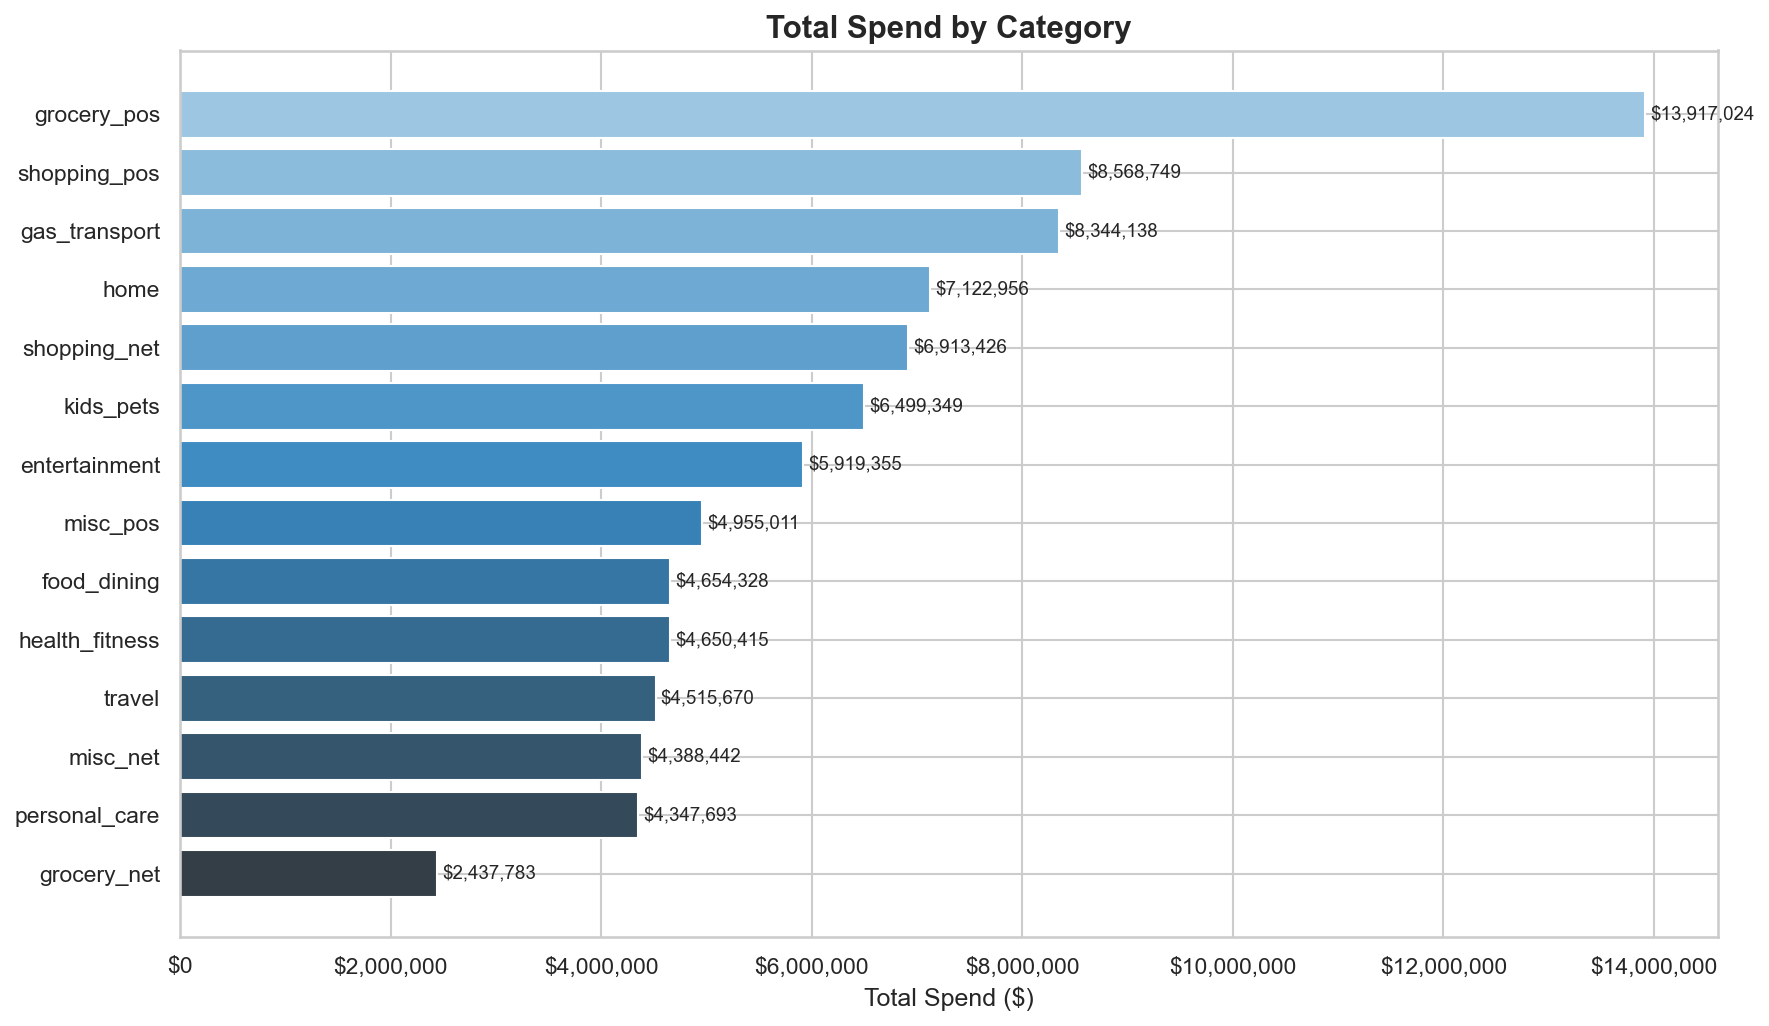

Chart 1 saved!


In [36]:
# --- CHART 1: Total Spend by Category (Horizontal Bar) ---

q1 = pd.read_csv('sql_analysis_results.xlsx') if False else None

# Re-run query from conn (make sure conn is still active in your session)
q1 = pd.read_sql("""
    SELECT category, ROUND(SUM(amt),2) AS total_spend, ROUND(SUM(revenue),2) AS total_revenue
    FROM transactions
    GROUP BY category ORDER BY total_spend DESC
""", conn)

colors = sns.color_palette("Blues_d", len(q1))

fig, ax = plt.subplots(figsize=(12, 7))
bars = ax.barh(q1['category'], q1['total_spend'], color=colors)
ax.set_xlabel('Total Spend ($)', fontsize=12)
ax.set_title('Total Spend by Category', fontsize=15, fontweight='bold')
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax.invert_yaxis()

# Add value labels
for bar, val in zip(bars, q1['total_spend']):
    ax.text(bar.get_width() + 50000, bar.get_y() + bar.get_height()/2,
            f'${val:,.0f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('chart1_spend_by_category.png', dpi=150, bbox_inches='tight')
plt.show()
print("Chart 1 saved!")

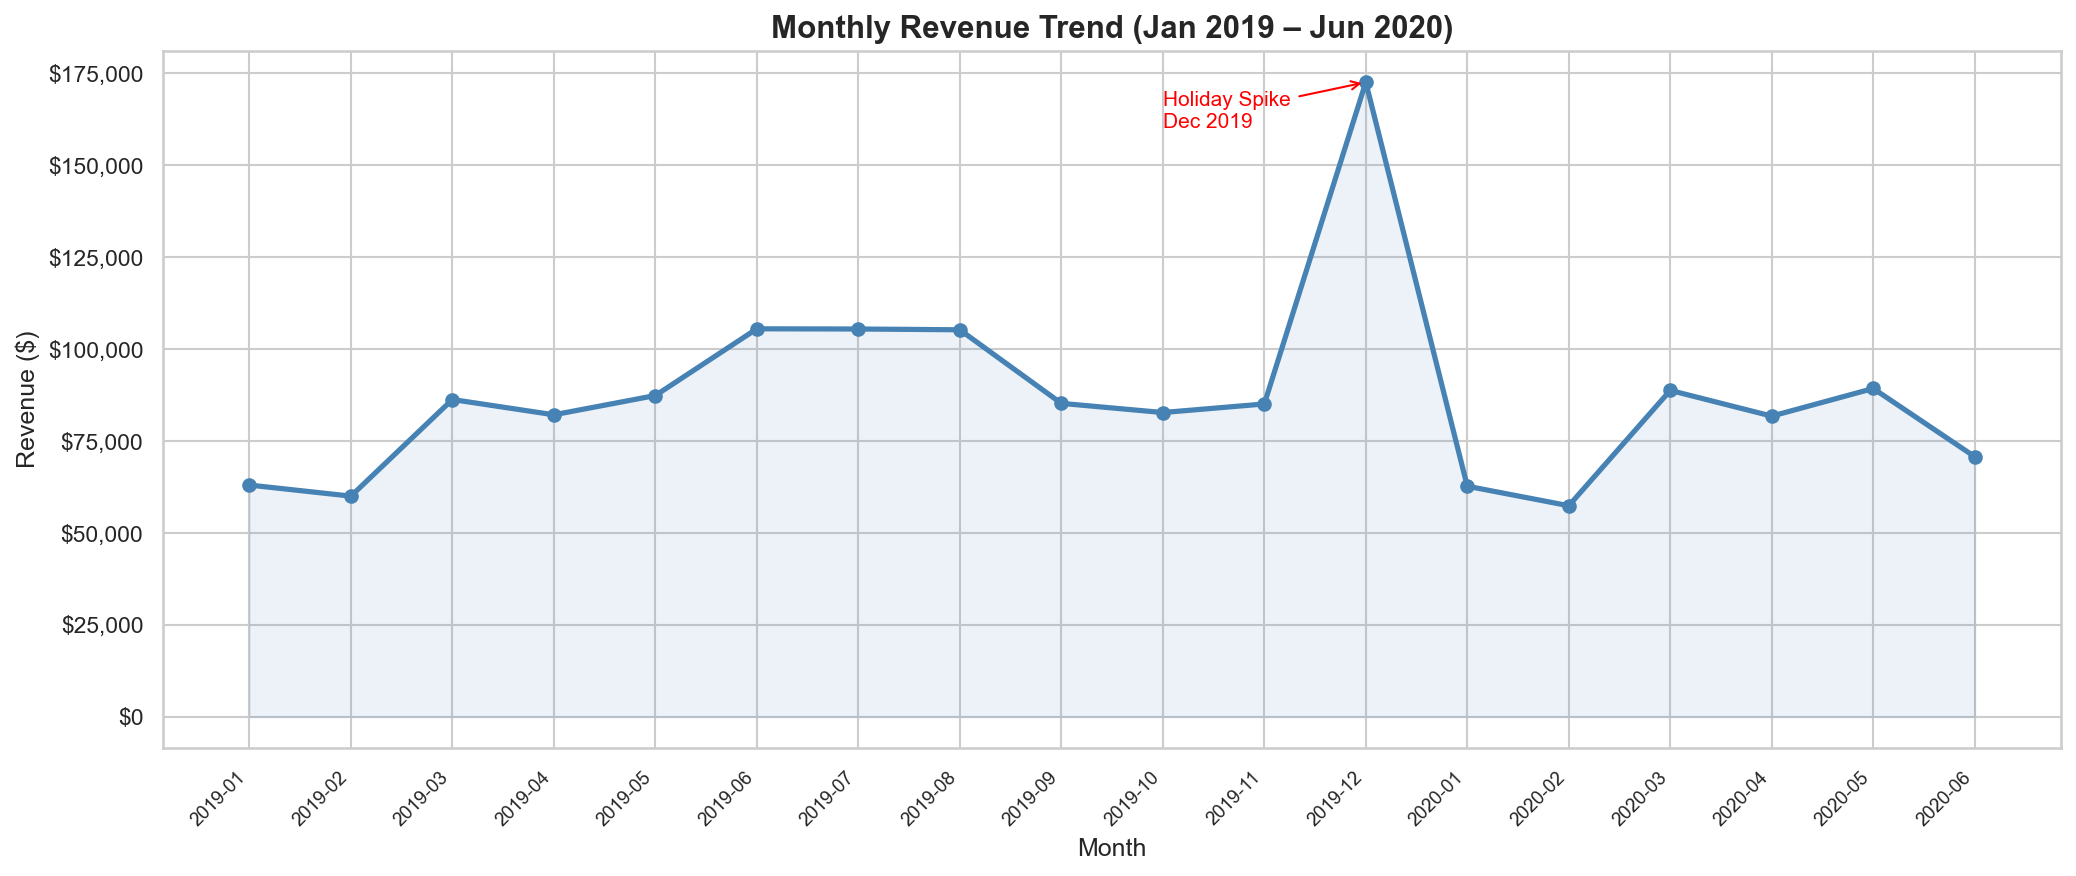

Chart 2 saved!


In [37]:
# --- CHART 2: Monthly Revenue Trend (Line Chart) ---

q2 = pd.read_sql("""
    SELECT trans_year, trans_month,
           ROUND(SUM(revenue),2) AS monthly_revenue,
           ROUND(SUM(amt),2) AS monthly_spend
    FROM transactions
    GROUP BY trans_year, trans_month ORDER BY trans_year, trans_month
""", conn)

q2['period'] = q2['trans_year'].astype(str) + '-' + q2['trans_month'].astype(str).str.zfill(2)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(q2['period'], q2['monthly_revenue'], marker='o', color='steelblue',
        linewidth=2.5, markersize=6, label='Monthly Revenue')
ax.fill_between(range(len(q2)), q2['monthly_revenue'], alpha=0.1, color='steelblue')

# Highlight December 2019 spike
dec_idx = q2[q2['period'] == '2019-12'].index[0]
ax.annotate('Holiday Spike\nDec 2019',
            xy=(list(q2['period']).index('2019-12'), q2.loc[dec_idx, 'monthly_revenue']),
            xytext=(list(q2['period']).index('2019-12') - 2, 160000),
            arrowprops=dict(arrowstyle='->', color='red'),
            fontsize=10, color='red')

ax.set_xticks(range(len(q2)))
ax.set_xticklabels(q2['period'], rotation=45, ha='right', fontsize=9)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax.set_title('Monthly Revenue Trend (Jan 2019 – Jun 2020)', fontsize=15, fontweight='bold')
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Revenue ($)', fontsize=12)
plt.tight_layout()
plt.savefig('chart2_monthly_revenue_trend.png', dpi=150, bbox_inches='tight')
plt.show()
print("Chart 2 saved!")

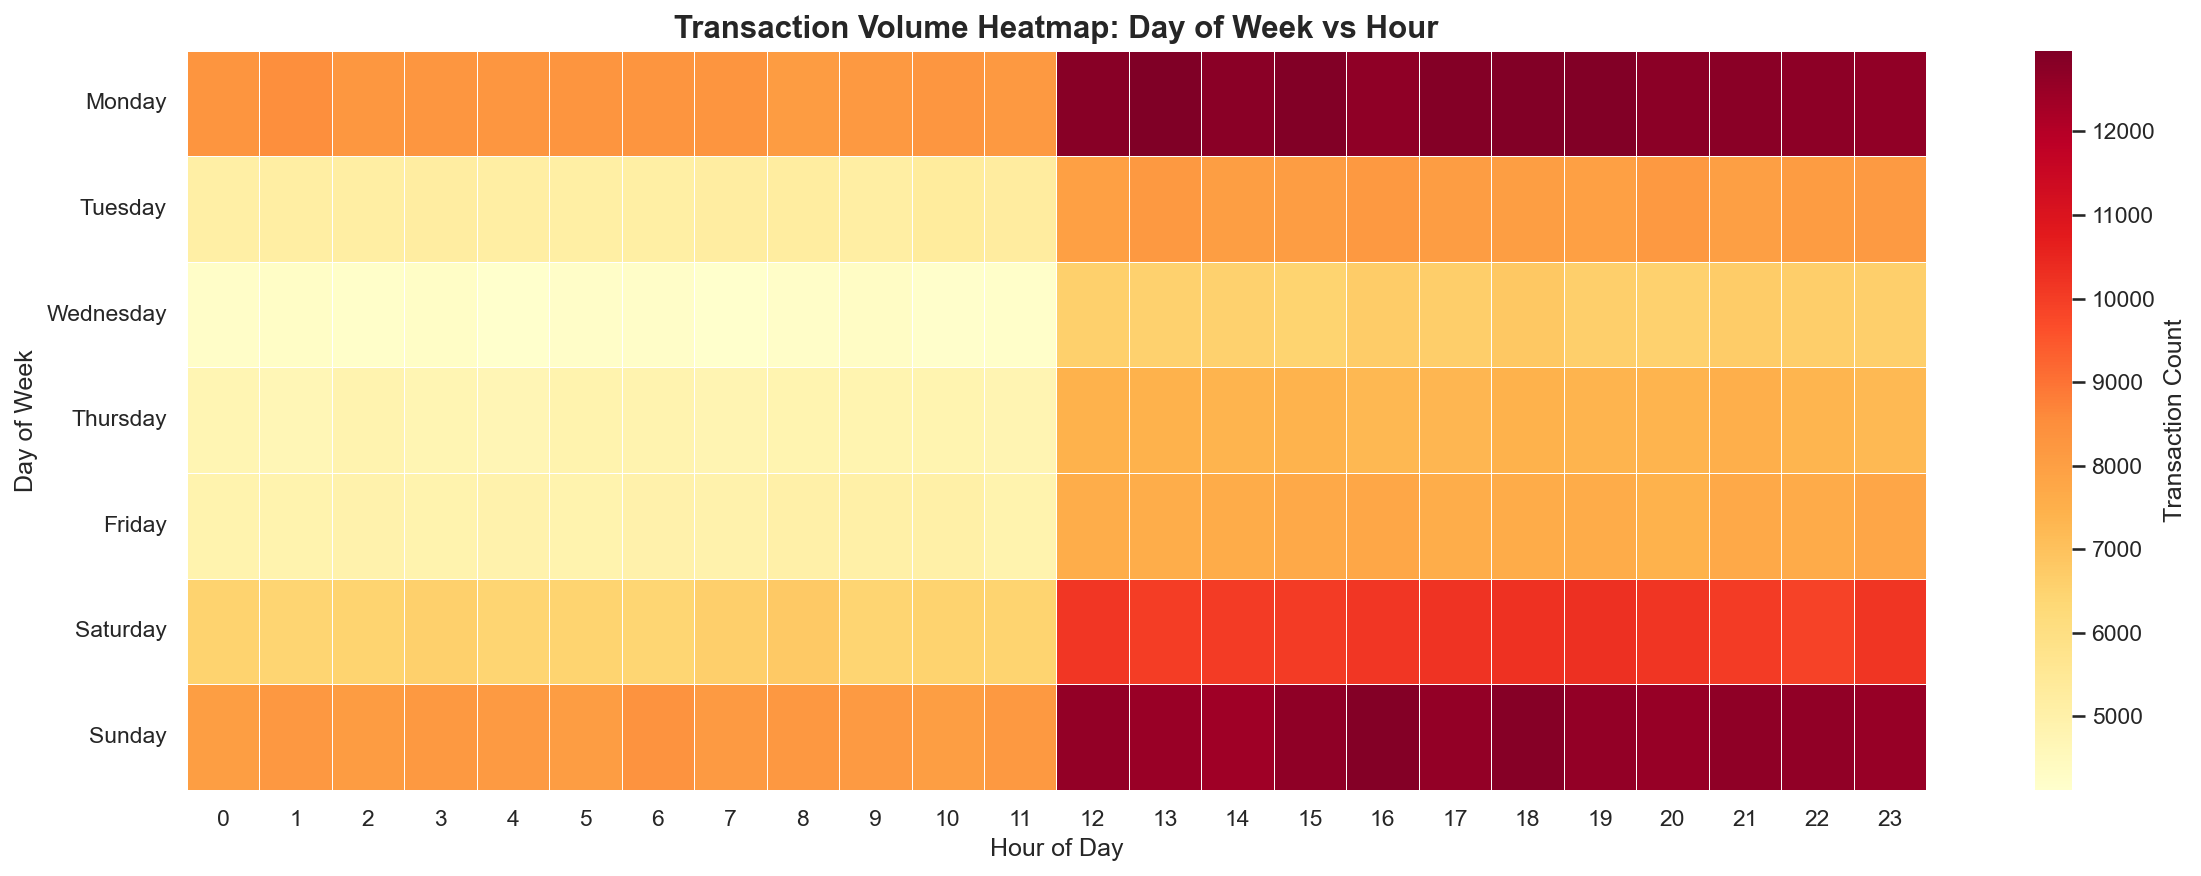

Chart 3 saved!


In [38]:
# --- CHART 3: Transaction Heatmap - Day of Week vs Hour ---

heatmap_data = pd.read_sql("""
    SELECT day_of_week, trans_hour, COUNT(*) AS txn_count
    FROM transactions
    GROUP BY day_of_week, trans_hour
""", conn)

pivot = heatmap_data.pivot(index='day_of_week', columns='trans_hour', values='txn_count')

# Order days correctly
day_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
pivot = pivot.reindex(day_order)

fig, ax = plt.subplots(figsize=(16, 6))
sns.heatmap(pivot, cmap='YlOrRd', ax=ax, fmt=',',
            linewidths=0.3, cbar_kws={'label': 'Transaction Count'})
ax.set_title('Transaction Volume Heatmap: Day of Week vs Hour', fontsize=15, fontweight='bold')
ax.set_xlabel('Hour of Day', fontsize=12)
ax.set_ylabel('Day of Week', fontsize=12)
plt.tight_layout()
plt.savefig('chart3_heatmap_day_hour.png', dpi=150, bbox_inches='tight')
plt.show()
print("Chart 3 saved!")

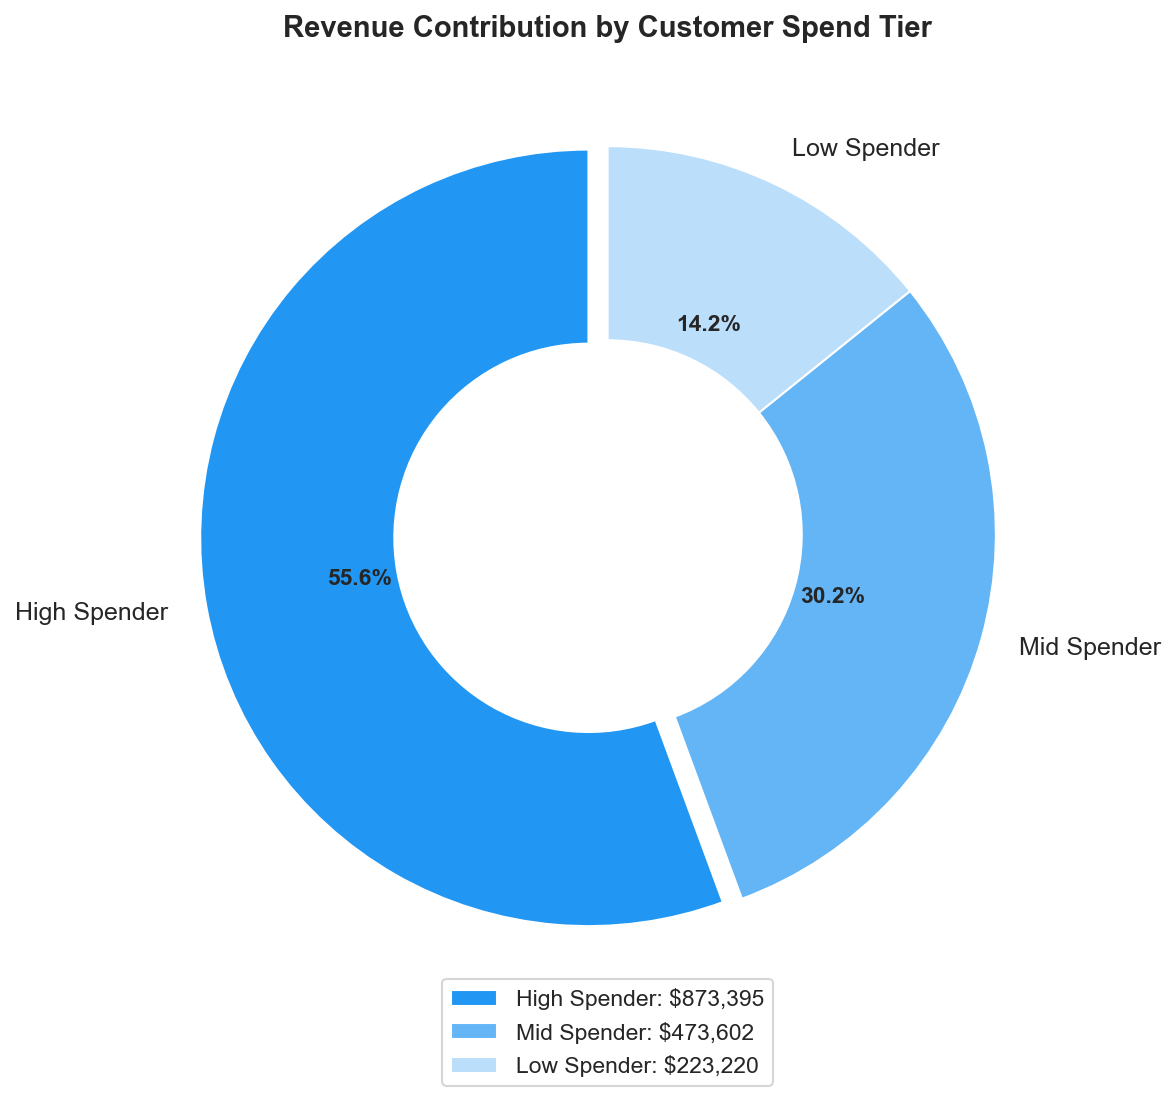

Chart 4 saved!


In [39]:
# --- CHART 4: Revenue by Customer Spend Tier (Donut Chart) ---

q7 = pd.read_sql("""
    SELECT spend_tier, ROUND(SUM(revenue),2) AS total_revenue
    FROM transactions
    GROUP BY spend_tier ORDER BY total_revenue DESC
""", conn)

colors = ['#2196F3', '#64B5F6', '#BBDEFB']
explode = (0.05, 0, 0)

fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(
    q7['total_revenue'], labels=q7['spend_tier'],
    autopct='%1.1f%%', startangle=90,
    colors=colors, explode=explode,
    wedgeprops=dict(width=0.5),
    textprops={'fontsize': 12}
)
for at in autotexts:
    at.set_fontsize(11)
    at.set_fontweight('bold')

ax.set_title('Revenue Contribution by Customer Spend Tier', fontsize=14, fontweight='bold')

# Add legend with dollar amounts
legend_labels = [f"{row['spend_tier']}: ${row['total_revenue']:,.0f}" for _, row in q7.iterrows()]
ax.legend(wedges, legend_labels, loc='lower center', bbox_to_anchor=(0.5, -0.08), fontsize=11)

plt.tight_layout()
plt.savefig('chart4_revenue_by_spend_tier.png', dpi=150, bbox_inches='tight')
plt.show()
print("Chart 4 saved!")

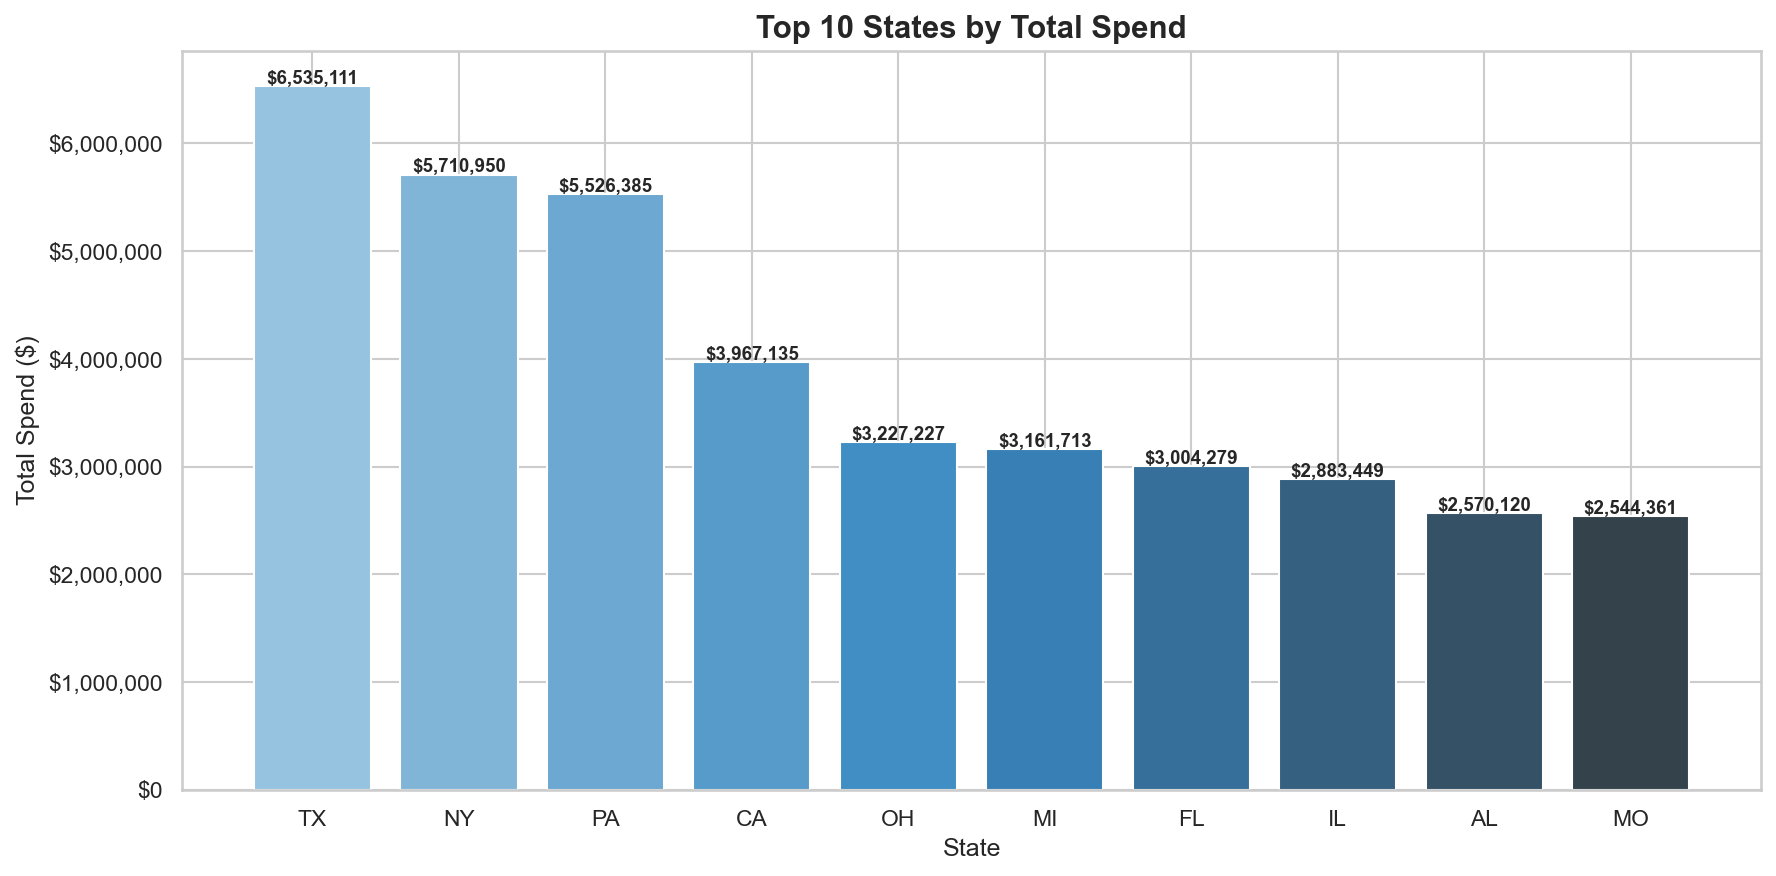

Chart 5 saved!


In [42]:
# --- CHART 5: Top 10 States by Total Spend (Bar Chart) ---

q3 = pd.read_sql("""
    SELECT state, ROUND(SUM(amt),2) AS total_spend
    FROM transactions
    GROUP BY state ORDER BY total_spend DESC LIMIT 10
""", conn)

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(q3['state'], q3['total_spend'],
              color=sns.color_palette('Blues_d', len(q3)))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))
ax.set_title('Top 10 States by Total Spend', fontsize=15, fontweight='bold')
ax.set_xlabel('State', fontsize=12)
ax.set_ylabel('Total Spend ($)', fontsize=12)

for bar, val in zip(bars, q3['total_spend']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20000,
            f'${val:,.0f}', ha='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('chart5_top10_states.png', dpi=150, bbox_inches='tight')
plt.show()
print("Chart 5 saved!")

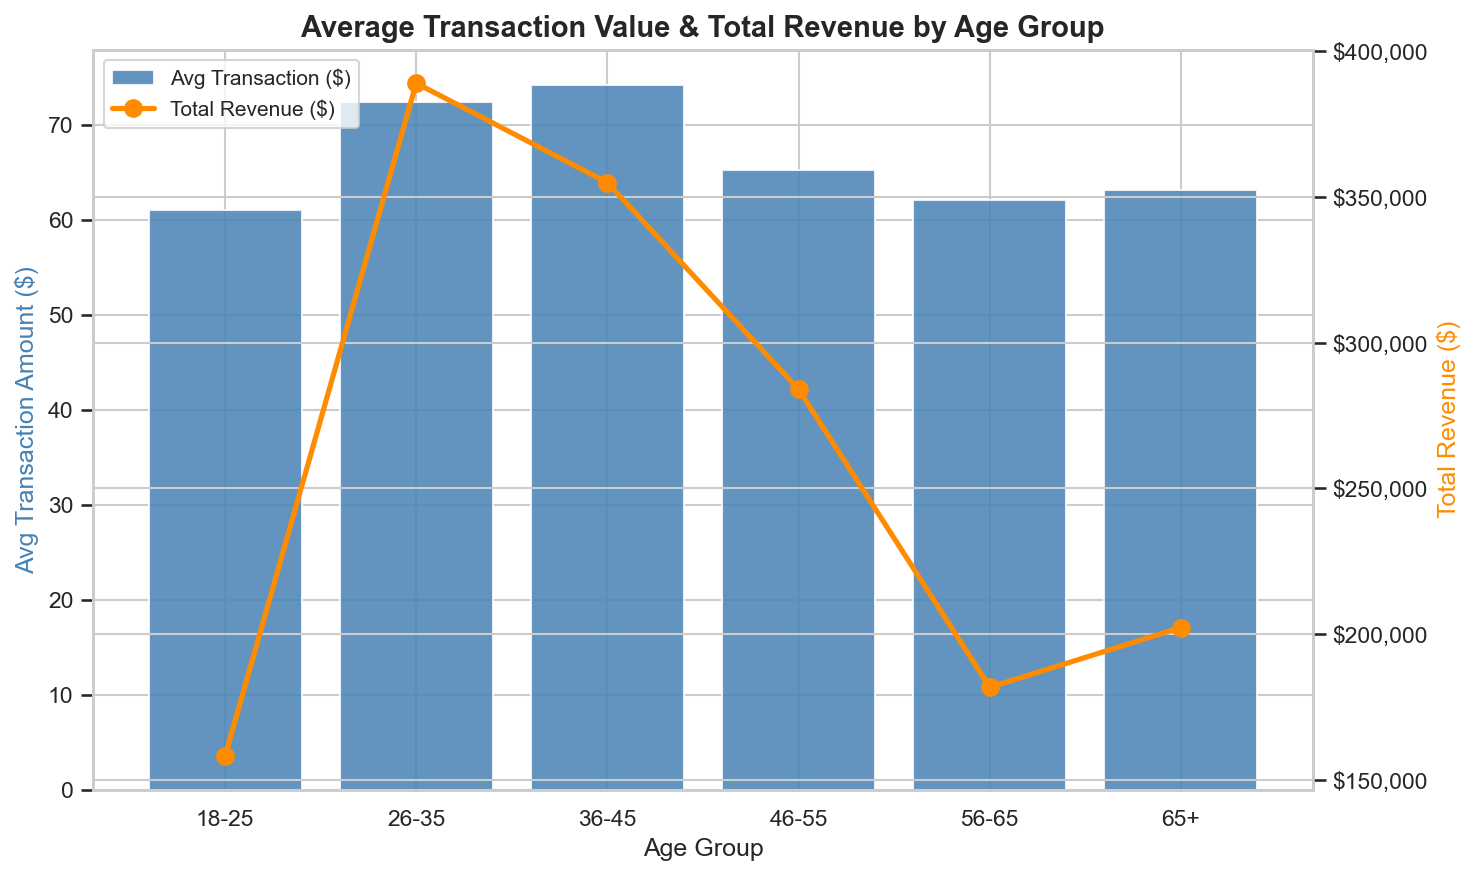

Chart 6 saved!


In [43]:
# --- CHART 6: Average Transaction by Age Group (Bar Chart) ---

q6 = pd.read_sql("""
    SELECT age_group, ROUND(AVG(amt),2) AS avg_transaction,
           ROUND(SUM(revenue),2) AS total_revenue
    FROM transactions
    GROUP BY age_group ORDER BY age_group
""", conn)

fig, ax1 = plt.subplots(figsize=(10, 6))

bars = ax1.bar(q6['age_group'], q6['avg_transaction'],
               color='steelblue', alpha=0.85, label='Avg Transaction ($)')
ax1.set_ylabel('Avg Transaction Amount ($)', fontsize=12, color='steelblue')
ax1.set_xlabel('Age Group', fontsize=12)
ax1.set_title('Average Transaction Value & Total Revenue by Age Group',
              fontsize=14, fontweight='bold')

# Overlay line for total revenue
ax2 = ax1.twinx()
ax2.plot(q6['age_group'], q6['total_revenue'], color='darkorange',
         marker='o', linewidth=2.5, markersize=8, label='Total Revenue ($)')
ax2.set_ylabel('Total Revenue ($)', fontsize=12, color='darkorange')
ax2.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'${x:,.0f}'))

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

plt.tight_layout()
plt.savefig('chart6_age_group_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
print("Chart 6 saved!")

EXCEL SUMMARY REPORT

In [44]:
# ============================================================
# STEP 5: EXCEL SUMMARY REPORT
# ============================================================

import pandas as pd
from openpyxl import load_workbook
from openpyxl.styles import (Font, PatternFill, Alignment, 
                              Border, Side, numbers)
from openpyxl.utils import get_column_letter
from openpyxl.chart import BarChart, LineChart, Reference
import sqlite3
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded!")

Libraries loaded!


In [45]:
# --- Pull all data needed for Excel ---

# KPI Summary
kpi = pd.read_sql("""
    SELECT 
        COUNT(*) AS total_transactions,
        COUNT(DISTINCT cc_num) AS total_customers,
        ROUND(SUM(amt), 2) AS total_spend,
        ROUND(AVG(amt), 2) AS avg_transaction,
        ROUND(SUM(revenue), 2) AS total_revenue,
        COUNT(DISTINCT category) AS total_categories,
        COUNT(DISTINCT state) AS total_states
    FROM transactions
""", conn)

# Category breakdown
cat = pd.read_sql("""
    SELECT category, COUNT(*) AS transactions,
           ROUND(SUM(amt),2) AS total_spend,
           ROUND(AVG(amt),2) AS avg_transaction,
           ROUND(SUM(revenue),2) AS total_revenue,
           ROUND(SUM(revenue)*100.0/(SELECT SUM(revenue) FROM transactions),2) AS revenue_pct
    FROM transactions
    GROUP BY category ORDER BY total_revenue DESC
""", conn)

# Monthly trend
monthly = pd.read_sql("""
    SELECT trans_year AS year, trans_month AS month,
           COUNT(*) AS transactions,
           ROUND(SUM(amt),2) AS total_spend,
           ROUND(SUM(revenue),2) AS total_revenue
    FROM transactions
    GROUP BY trans_year, trans_month ORDER BY trans_year, trans_month
""", conn)

# Spend tier
tier = pd.read_sql("""
    SELECT spend_tier, COUNT(DISTINCT cc_num) AS customers,
           COUNT(*) AS transactions,
           ROUND(SUM(amt),2) AS total_spend,
           ROUND(SUM(revenue),2) AS total_revenue,
           ROUND(SUM(revenue)*100.0/(SELECT SUM(revenue) FROM transactions),2) AS revenue_pct
    FROM transactions
    GROUP BY spend_tier ORDER BY total_revenue DESC
""", conn)

# Top 10 states
states = pd.read_sql("""
    SELECT state, COUNT(*) AS transactions,
           ROUND(SUM(amt),2) AS total_spend,
           ROUND(SUM(revenue),2) AS total_revenue
    FROM transactions
    GROUP BY state ORDER BY total_revenue DESC LIMIT 10
""", conn)

# Age group
age = pd.read_sql("""
    SELECT age_group, COUNT(*) AS transactions,
           ROUND(AVG(amt),2) AS avg_transaction,
           ROUND(SUM(revenue),2) AS total_revenue
    FROM transactions
    GROUP BY age_group ORDER BY age_group
""", conn)

print("All data pulled successfully!")

All data pulled successfully!


In [46]:
# --- Write to Excel with formatting ---

filepath = 'CC_Spend_Revenue_Analysis.xlsx'

with pd.ExcelWriter(filepath, engine='openpyxl') as writer:

    # Sheet 1: KPI Summary
    kpi_display = pd.DataFrame({
        'KPI': ['Total Transactions', 'Total Customers', 'Total Spend ($)',
                'Avg Transaction ($)', 'Total Revenue ($)',
                'Spending Categories', 'States Covered'],
        'Value': [
            f"{kpi['total_transactions'][0]:,}",
            f"{kpi['total_customers'][0]:,}",
            f"${kpi['total_spend'][0]:,.2f}",
            f"${kpi['avg_transaction'][0]:,.2f}",
            f"${kpi['total_revenue'][0]:,.2f}",
            f"{kpi['total_categories'][0]}",
            f"{kpi['total_states'][0]}"
        ]
    })
    kpi_display.to_excel(writer, sheet_name='KPI Summary', index=False, startrow=2)

    # Sheet 2: Category Analysis
    cat.to_excel(writer, sheet_name='Category Analysis', index=False, startrow=1)

    # Sheet 3: Monthly Trend
    monthly.to_excel(writer, sheet_name='Monthly Trend', index=False, startrow=1)

    # Sheet 4: Customer Spend Tier
    tier.to_excel(writer, sheet_name='Spend Tier', index=False, startrow=1)

    # Sheet 5: Top States
    states.to_excel(writer, sheet_name='Top States', index=False, startrow=1)

    # Sheet 6: Age Group
    age.to_excel(writer, sheet_name='Age Group', index=False, startrow=1)

print("Excel file written. Now applying formatting...")

Excel file written. Now applying formatting...


In [47]:
# --- Apply Professional Formatting ---

wb = load_workbook(filepath)

# Define styles
header_font = Font(bold=True, color='FFFFFF', size=11)
header_fill = PatternFill(fill_type='solid', fgColor='1F4E79')  # Dark navy
title_font  = Font(bold=True, size=13, color='1F4E79')
alt_fill    = PatternFill(fill_type='solid', fgColor='D6E4F0')  # Light blue
border_side = Side(style='thin', color='CCCCCC')
thin_border = Border(left=border_side, right=border_side,
                     top=border_side, bottom=border_side)

def format_sheet(ws, title_text, header_row=3):
    # Add title in row 1
    ws.cell(row=1, column=1).value = title_text
    ws.cell(row=1, column=1).font = title_font
    ws.cell(row=1, column=1).alignment = Alignment(horizontal='left')

    # Format header row
    for cell in ws[header_row]:
        if cell.value:
            cell.font = header_font
            cell.fill = header_fill
            cell.alignment = Alignment(horizontal='center', vertical='center')
            cell.border = thin_border

    # Format data rows with alternating colors
    for i, row in enumerate(ws.iter_rows(min_row=header_row+1)):
        for cell in row:
            cell.border = thin_border
            cell.alignment = Alignment(horizontal='center')
            if i % 2 == 0:
                cell.fill = alt_fill

    # Auto-fit column widths
    for col in ws.columns:
        max_len = 0
        col_letter = get_column_letter(col[0].column)
        for cell in col:
            if cell.value:
                max_len = max(max_len, len(str(cell.value)))
        ws.column_dimensions[col_letter].width = max_len + 4

# Format each sheet
format_sheet(wb['KPI Summary'],        '📊 Executive KPI Summary — Credit Card Spend & Revenue Analysis', header_row=3)
format_sheet(wb['Category Analysis'],  '📂 Revenue & Spend Breakdown by Category', header_row=2)
format_sheet(wb['Monthly Trend'],      '📅 Monthly Spend & Revenue Trend (Jan 2019 – Jun 2020)', header_row=2)
format_sheet(wb['Spend Tier'],         '👥 Customer Spend Tier Analysis', header_row=2)
format_sheet(wb['Top States'],         '🗺️ Top 10 States by Revenue', header_row=2)
format_sheet(wb['Age Group'],          '🎂 Spend & Revenue by Customer Age Group', header_row=2)

wb.save(filepath)
print(f"Formatted Excel file saved: {filepath}")

Formatted Excel file saved: CC_Spend_Revenue_Analysis.xlsx


POWER BI PREPERATION

In [48]:
# ============================================================
# STEP 6 PREP: EXPORT CSVs FOR POWER BI
# ============================================================

# 1. Main cleaned transactions (already saved, just confirm)
print("Main file: credit_card_cleaned.csv ✅")

# 2. Category Analysis
cat.to_csv('pbi_category.csv', index=False)
print("Saved: pbi_category.csv ✅")

# 3. Monthly Trend
monthly.to_csv('pbi_monthly.csv', index=False)
print("Saved: pbi_monthly.csv ✅")

# 4. Spend Tier
tier.to_csv('pbi_spend_tier.csv', index=False)
print("Saved: pbi_spend_tier.csv ✅")

# 5. Top States
states_all = pd.read_sql("""
    SELECT state, COUNT(*) AS transactions,
           ROUND(SUM(amt),2) AS total_spend,
           ROUND(SUM(revenue),2) AS total_revenue
    FROM transactions
    GROUP BY state ORDER BY total_revenue DESC
""", conn)
states_all.to_csv('pbi_states.csv', index=False)
print("Saved: pbi_states.csv ✅")

# 6. Age Group
age.to_csv('pbi_age_group.csv', index=False)
print("Saved: pbi_age_group.csv ✅")

# 7. Customer LTV
clv = pd.read_sql("""
    SELECT cc_num, spend_tier,
           COUNT(*) AS transactions,
           ROUND(SUM(amt),2) AS total_spend,
           ROUND(SUM(revenue),2) AS total_revenue
    FROM transactions
    GROUP BY cc_num ORDER BY total_revenue DESC
""", conn)
clv.to_csv('pbi_customer_ltv.csv', index=False)
print("Saved: pbi_customer_ltv.csv ✅")

print("\nAll Power BI source files ready!")

Main file: credit_card_cleaned.csv ✅
Saved: pbi_category.csv ✅
Saved: pbi_monthly.csv ✅
Saved: pbi_spend_tier.csv ✅
Saved: pbi_states.csv ✅
Saved: pbi_age_group.csv ✅
Saved: pbi_customer_ltv.csv ✅

All Power BI source files ready!
